# Front end for LSH project

In [103]:
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
utils_path=os.path.abspath("../utils")
upper_path=os.path.abspath("../")


sys.path.append(utils_path)
sys.path.append(upper_path)

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from math import sqrt
import json
# import plotly.express as px
%load_ext autoreload
%autoreload 2

# custom modules
from utils import preprocess
from utils.preprocess import Preprocess , create_train_test
from utils.min_hash import MinHash
from utils.near_neighbors import fill_buckets, search_similar_vectors,jaccard,pearson,pearson2, predict_rating
from utils.model_evalutation import compute_mse, generate_infered_ratings_array, complete_mse_computation
from utils.near_neighbors import generate_similarity_matrix,generate_bruteforce_jaccard_matrix
from utils.s_curve import generate_s_curve_data, generate_s_curve_plot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Defining paths for dataset

In [11]:
DATA_FOLDER="../data"
small_dataset_path=Path(DATA_FOLDER,"ml-latest-small","ratings.csv")
small_dataset_df=pd.read_csv(small_dataset_path)

# large_dataset_path=Path(DATA_FOLDER,"ml-25m","ratings.csv")
# large_dataset_df=pd.read_csv(large_dataset_path)
# large_dataset_df.columns


### 2. Preprocessing the data

In [12]:
Preprocessing=Preprocess(small_dataset_path)
Preprocessing.preprocess_ratings_np(rating_threshold=3)
full_rating_array=Preprocessing.ratings_array
threshold_rating_array=Preprocessing.threshold_ratings_array

print("Size in MB")
print(threshold_rating_array.nbytes/10**6)
print(full_rating_array.nbytes/10**6)

Removing 0 irrelevent users
Size in MB
5.93164
5.93164


## Creating models and testing them on the test set

In [13]:
test_ids,threshold_array_train,rating_array_copy=create_train_test(threshold_rating_array,full_rating_array)

In [15]:
similarity_matrix_bruteforce_jac=generate_bruteforce_jaccard_matrix(threshold_array_train)

Going through user_2 = 609/610 user_1 = 608/610
The maximum similarity for Jaccart is 0.7


## Going through the different configurations to find the best parameters

In [101]:
# generate different instances of the MinHash object :
signature_sizes=[64,128,256]

# signature_size=64
nb_instances=30
MH_instances={}
MSEs={k:[] for k in signature_sizes}
for signature_size in signature_sizes:
    n_rows=1
    n_bands=signature_size
    for k in range(nb_instances):
        MH_instances[k]=MinHash(vector_size=threshold_array_train.shape[1],n_rows=n_rows,n_bands=n_bands,seed=k)

    MSE_specif={2**k:[] for k in range(int(sqrt(signature_size))) }
    simi_matrices={}
    for instance_index in range(nb_instances):
        n_rows=1
        n_bands=signature_size
        condition = (n_bands %2 ==0)
        while condition: #while possible to split the bands
            print(f"Signature: {signature_size},Instance {instance_index}. rows {n_rows} bands {n_bands}",end="\r")
            MH_instances[instance_index].__changebands__(n_bands=n_bands,n_rows=n_rows)
            MH_instances[instance_index].__emptyhashes__()
            time_fill=fill_buckets(threshold_array_train,MH_instances[instance_index],verbose=False,return_time=True)
            # time_fill_buckets.append(time_fill)

            similarity_matrix=generate_similarity_matrix(threshold_array_train,MH_instances[instance_index])
            mse=complete_mse_computation(test_ids,similarity_matrix,rating_array_copy)
            simi_matrices[n_bands]=similarity_matrix
            MSE_specif[n_rows].append(mse)

            # s_curves_data[n_rows]=generate_s_curve_data(n_division=20,computed_simi_matrix=similarity_matrix,complete_simi_matrix=similarity_matrix_bruteforce_jac,max_simi=0.7)
            
            condition = (n_bands %2 ==0)
            n_rows*=2
            n_bands//=2
    MSEs[signature_size]=MSE_specif

# with open ("../backup_MSE_jaccard.json","w") as f:
#     json.dump(MSEs,f)

In [153]:
MSE_specif

{1: [39.209391598359076], 2: [42.43588937541932]}

In [154]:
# generate different instances of the MinHash object :
signature_sizes=[8]

# signature_size=64
nb_instances=30
MH_instances={}
MSE8={k:[] for k in signature_sizes}
for signature_size in signature_sizes:
    n_rows=1
    n_bands=signature_size
    for k in range(nb_instances):
        MH_instances[k]=MinHash(vector_size=threshold_array_train.shape[1],n_rows=n_rows,n_bands=n_bands,seed=k)

    MSE_specif={2**k:[] for k in range(4) }
    simi_matrices={}
    for instance_index in range(nb_instances):
        n_rows=1
        n_bands=signature_size
        condition = (n_bands %2 ==0)
        while condition: #while possible to split the bands
            print(f"Signature: {signature_size},Instance {instance_index}. rows {n_rows} bands {n_bands}",end="\r")
            MH_instances[instance_index].__changebands__(n_bands=n_bands,n_rows=n_rows)
            MH_instances[instance_index].__emptyhashes__()
            time_fill=fill_buckets(threshold_array_train,MH_instances[instance_index],verbose=False,return_time=True)
            # time_fill_buckets.append(time_fill)

            similarity_matrix=generate_similarity_matrix(threshold_array_train,MH_instances[instance_index])
            mse=complete_mse_computation(test_ids,similarity_matrix,rating_array_copy)
            simi_matrices[n_bands]=similarity_matrix
            MSE_specif[n_rows].append(mse)

            # s_curves_data[n_rows]=generate_s_curve_data(n_division=20,computed_simi_matrix=similarity_matrix,complete_simi_matrix=similarity_matrix_bruteforce_jac,max_simi=0.7)
            
            condition = (n_bands %2 ==0)
            n_rows*=2
            n_bands//=2
    MSE8[signature_size]=MSE_specif

# with open ("../backup_MSE_jaccard.json","w") as f:
#     json.dump(MSEs,f)

In [159]:
sign8array=[np.average(el) for el in MSE8[8].values()]
sign8array

[38.72705709064242, 42.74466745155977, 58.33213132243614, 61.49504663863277]

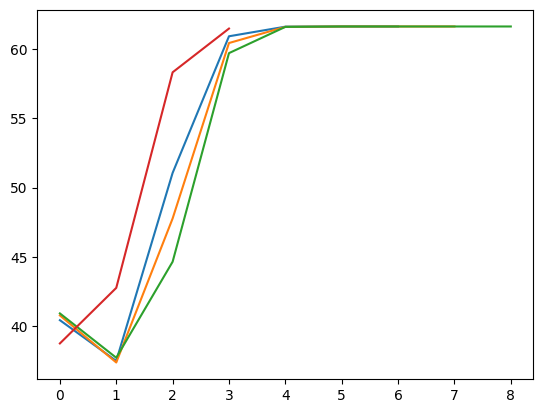

In [160]:
for k in range(0,3):
    # print("k
    plt.plot(dic_MSEs[64*2**k])
plt.plot(sign8array)

In [129]:
dic_MSEs={}
for signature_size in signature_sizes:
    dic_MSEs[signature_size]=[np.average(band_arr) for band_arr in MSEs[signature_size].values()]

In [137]:
MSEs[256].keys()

dict_keys([1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768])

In [163]:
with open('../averaged_MSEs_Jaccard.json','w') as f:
    json.dump(dic_MSEs,f)

/Users/bensykes/Documents/Etudes/Master IASD/Data Science Project/LSH Project/venvLSH/lib/python3.10/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/bensykes/Documents/Etudes/Master IASD/Data Science Project/LSH Project/venvLSH/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


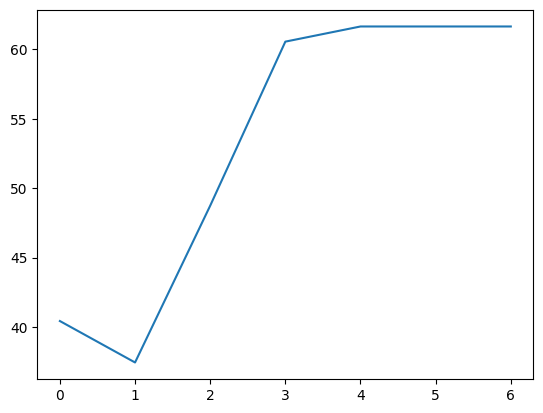

In [95]:
MSEs_avgd=np.array([np.average(MSEs[2**k]) for k in range(len(MSEs))])
plt.plot(MSEs_avgd)

In [21]:
signature_size=[64,128,256]
n_rows=1
n_bands=128
condition = (n_bands %2 ==0)
simi_matrices={}
time_fill_buckets=[]
MSEs=[]
s_curves_data={}
MH=MinHash(vector_size=threshold_array_train.shape[1],n_rows=n_rows,n_bands=n_bands)

while condition: #while possible to split the bands
    print(f"rows {n_rows} bands {n_bands}",end="\r")
    MH.__changebands__(n_bands=n_bands,n_rows=n_rows)
    MH.__emptyhashes__()
    time_fill=fill_buckets(threshold_array_train,MH,verbose=False,return_time=True)
    time_fill_buckets.append(time_fill)

    similarity_matrix=generate_similarity_matrix(threshold_array_train,MH)
    mse=complete_mse_computation(test_ids,similarity_matrix,rating_array_copy)
    simi_matrices[n_bands]=similarity_matrix
    MSEs.append(mse)

    s_curves_data[n_rows]=generate_s_curve_data(n_division=20,computed_simi_matrix=similarity_matrix,complete_simi_matrix=similarity_matrix_bruteforce_jac,max_simi=0.7)
    
    condition = (n_bands %2 ==0)
    n_rows*=2
    n_bands//=2


rows 1 bands 128
Filled buckets in 0.94 seconds
rows 2 bands 64
Filled buckets in 0.91 seconds
rows 4 bands 32
Filled buckets in 0.93 seconds
rows 8 bands 16
Filled buckets in 0.88 seconds
rows 16 bands 8
Filled buckets in 0.9 seconds
rows 32 bands 4
Filled buckets in 0.88 seconds
rows 64 bands 2
Filled buckets in 0.89 seconds
rows 128 bands 1
Filled buckets in 0.9 seconds


In [27]:
# generate_s_curve_plot(n_division=20,computed_simi_matrix=simi_matrices[8],complete_simi_matrix=similarity_matrix_bruteforce_jac,max_simi=0.7)

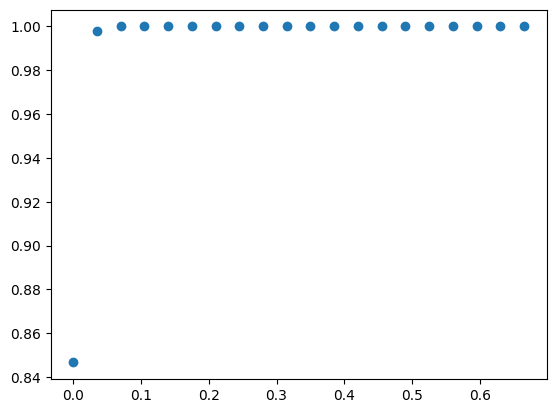

In [22]:
indexx=1
plt.scatter(s_curves_data[indexx][0],s_curves_data[indexx][1])

Text(0.5, 1.0, 'MSE with varying number of rows on signature size 512')

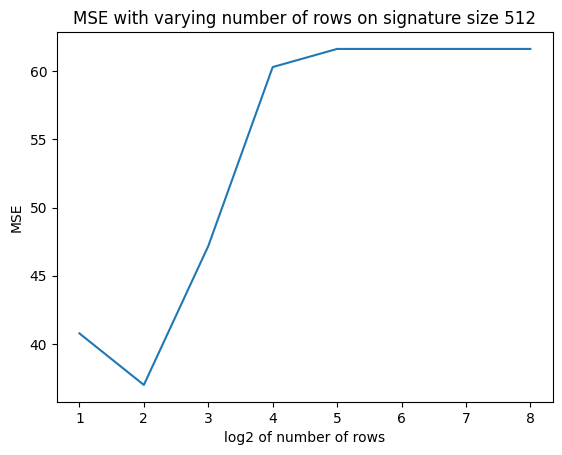

In [23]:
x=[k+1 for k in range(len(MSEs))]
plt.plot(x,MSEs)
plt.xticks(x)
plt.xlabel("log2 of number of rows")
plt.ylabel("MSE")
plt.title("MSE with varying number of rows on signature size 512")
# plt.savefig("../figures/MSE 512 size band")

In [27]:
s_curves_data.keys()

dict_keys([1, 2, 4, 8, 16, 32, 64, 128])

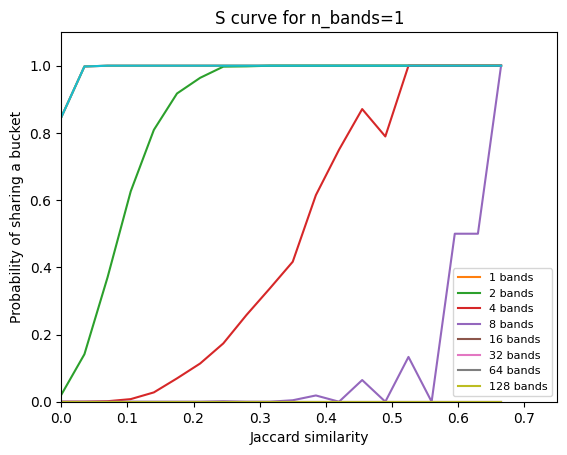

In [61]:
fig = plt.figure()

def init():
    plt.plot(s_curves_data[1][0],s_curves_data[1][1])
    plt.xlim(0,0.75)
    plt.ylim(0,1.1)

    plt.title(f"S curve for n_bands={2**0}")


def animate(i):

    plt.plot(s_curves_data[2**i][0],s_curves_data[2**i][1],label=f"{2**i} bands")
    plt.title(f"S curve for n_bands={2**i}")
    plt.xlim(0,0.75)
    plt.ylim(0,1.1)
    plt.legend(prop={'size': 8})

plt.xlabel("Jaccard similarity")
plt.ylabel("Probability of sharing a bucket")
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=8, interval=10_000 ,repeat = True)

# anim.save("../figures/s-curves_animation.gif", writer=PillowWriter(fps=2))
anim


In [49]:
f"{2**i} bands"

'128 bands'

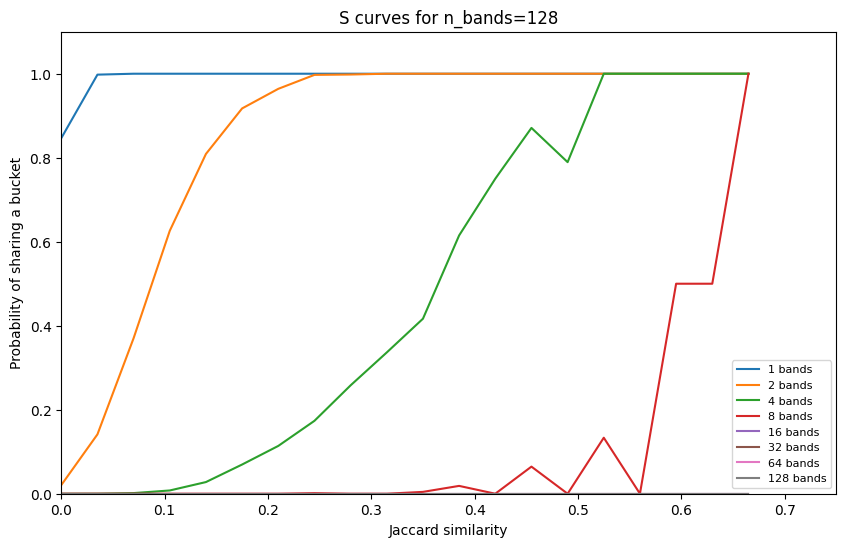

In [65]:
plt.figure(figsize=(10,6))
for i in range(8):

    plt.plot(s_curves_data[2**i][0],s_curves_data[2**i][1],label=f"{2**i} bands")
    plt.title(f"S curves for n_bands={2**i}")

    plt.xlim(0,0.75)
    plt.ylim(0,1.1)


plt.xlabel("Jaccard similarity")
plt.ylabel("Probability of sharing a bucket")
    
plt.legend(prop={'size': 8})
# plt.savefig("../figures/S curves for sign length of 128.png")


### LSH algorithm

### Ploting the bucket sizes histogram

In [52]:
# buckets_sizes=[]
# for band_index in range(MH.n_bands):
#     for values in MH.hashes[band_index].values():
#         buckets_sizes.append(len(values))
        

# from collections import Counter
# from math import log10
# dic_bucksize=Counter(buckets_sizes)
# dic={k:log10(v) for k,v in dic_bucksize.items()}

# px.histogram(dic.keys(),dic.values())

### Infering similar users for a specific user

### Infer rating of a specific movie

## Computing similarities based on LSH

## Computing all the similarities (brute force)

### Using Jaccart

Going through user_2 = 609/610 user_1 = 608/610
The maximum similarity for Jaccart is 0.7


### Using Pearson

In [26]:
similarity_matrix_bruteforce_pear=np.empty(shape=(threshold_rating_array.shape[0],threshold_rating_array.shape[0]))
similarity_matrix_bruteforce_pear[:]=np.nan
# setting matrix values to nan by default and computing the simi only if the one in the upper diag hasn't been computed ye
for user2_index,user2_vector in enumerate(full_rating_array):
    for user1_index,user1_vector in enumerate(full_rating_array[:user2_index,:]):
        print(f"Going through user_2 = {user2_index}/{full_rating_array.shape[0]} user_1 = {user1_index}/{full_rating_array.shape[0]}",end="\r")
        similarity_matrix_bruteforce_pear[user1_index][user2_index]=pearson(
            vectors=full_rating_array,idxU=user1_index,idxV=user2_index)
    # np.nan_to_num(similarity_matrix_bruteforce_pear,copy=False)
print(f"\nThe maximum similarity for Pearson is {np.nanmax(similarity_matrix_bruteforce_pear)}")


Going through user_2 = 609/610 user_1 = 608/610
The maximum similarity for Pearson is 1.0000000000000004


In [22]:
fig=plt.imshow(similarity_matrix_bruteforce_pear)
# cb = plt.figure.colorbar(fig)
# Match the seaborn style
# cb.outline.set_visible(False)

NameError: name 'similarity_matrix_bruteforce_pear' is not defined

In [29]:
# np.nanmax(similarity_matrix_bruteforce_pear)

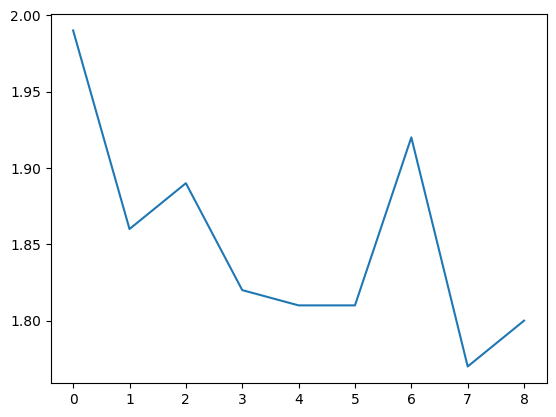

In [23]:
plt.plot(np.array([k for k in range(len(time_fill_buckets))]),time_fill_buckets)

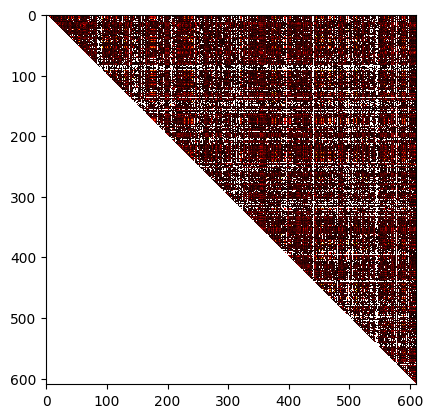

In [24]:
plt.imshow(simi_matrices[256], cmap='hot', interpolation='nearest')
plt.show()

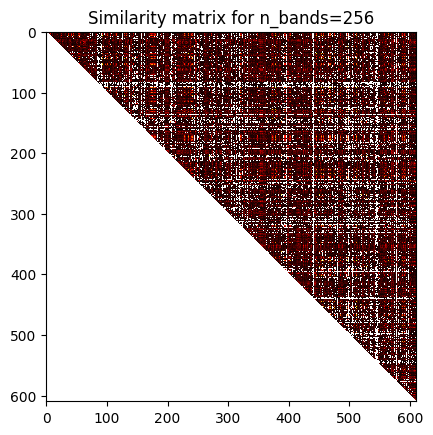

In [40]:




fig = plt.figure()

def init():
    plt.imshow(simi_matrices[1], cmap='hot', interpolation='nearest')      
def animate(i):
    plt.imshow(simi_matrices[2**i], cmap='hot', interpolation='nearest')
    plt.title(f"Similarity matrix for n_bands={2**i}")

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=9, interval=10_000 ,repeat = True)

# anim.save("simi.gif", writer=PillowWriter(fps=2))
anim


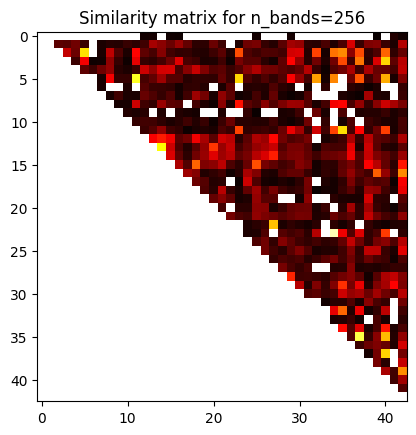

In [42]:
fig = plt.figure()

def init():
    plt.imshow(simi_matrices[1][2:45,2:45], cmap='hot', interpolation='nearest')      
def animate(i):
    plt.imshow(simi_matrices[2**i][2:45,2:45], cmap='hot', interpolation='nearest')
    plt.title(f"Similarity matrix for n_bands={2**i}")

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=9, interval=10_000 ,repeat = True)

# anim.save("simi_zoomed.gif", writer=PillowWriter(fps=2))
anim


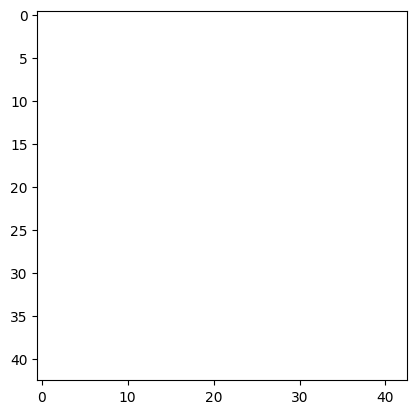

In [118]:
fig = plt.figure()

def init():
    plt.imshow(simi_matrices[1][2:45,2:45], cmap='hot', interpolation='nearest')      
def animate(i):
    plt.imshow(simi_matrices[2**i][2:45,2:45], cmap='hot', interpolation='nearest')
    plt.title(f"Similarity matrix for n_bands={2**i}")

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=9, interval=10_000 ,repeat = True)

# anim.save("simi_zoomed.gif", writer=PillowWriter(fps=2))
anim

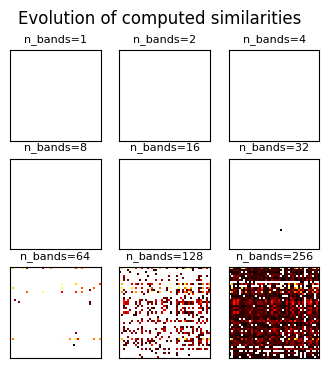

In [166]:
fig = plt.figure(figsize=(4,4))

# plt.

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(simi_matrices[2**i][45:90,100:145], cmap='hot', interpolation='nearest')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"n_bands={2**i}",fontsize=8)
    # ax.axis('off')
fig.suptitle("Evolution of computed similarities", fontsize=12)
# plt.savefig("Evolution of computed similarities zoomed.png")


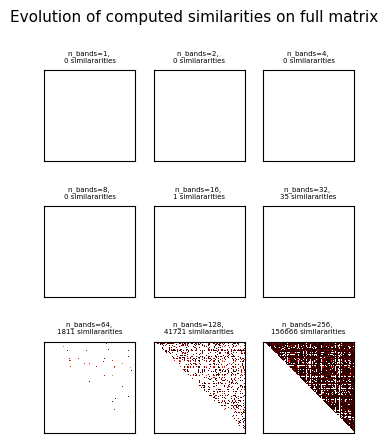

In [183]:
fig = plt.figure(figsize=(4,5))

# plt.

for i in range(9):
    ax = fig.add_subplot(3, 3, i+1)
    ax.imshow(simi_matrices[2**i], cmap='hot', interpolation='nearest')
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(f"n_bands={2**i}, \n{np.count_nonzero(~np.isnan(simi_matrices[2**i]))} similararities",fontsize=5)
    # ax.axis('off')
fig.suptitle("Evolution of computed similarities on full matrix", fontsize=11)
plt.savefig("Evolution of computed similarities full matrix.png")


In [98]:
user_index=340
movie_index=0

similarity_matrix=similarity_matrix_bruteforce_pear


predict_rating(user_index,movie_index,similarity_matrix,full_rating_array,normalisation_factor=1)


3.1671462285718044

## S Curve

In [34]:
inpuv=np.nan_to_num(simi_matrices[256].reshape(-1))

In [39]:
n_dig=3
inpuv=np.array([round(el,n_dig) for el in inpuv])
from collections import Counter
cnt=Counter(inpuv)

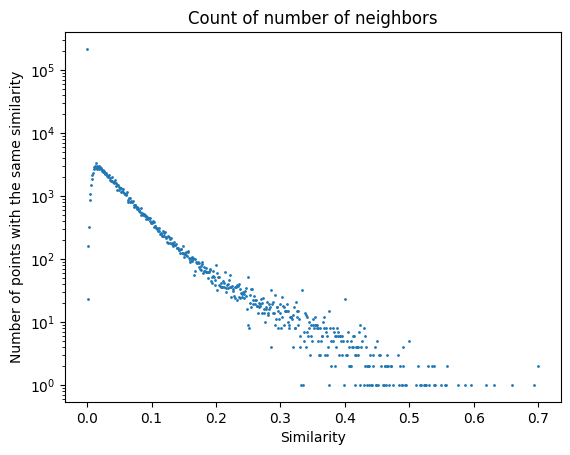

In [56]:
plt.yscale('log',base=10) 

plt.scatter(cnt.keys(),cnt.values(),s=1)
plt.xlabel("Similarity")
plt.ylabel("Number of points with the same similarity")# (rounded at 3 decimals)")
plt.title("Count of number of neighbors")
plt.savefig("Count of number of neighbors.png")

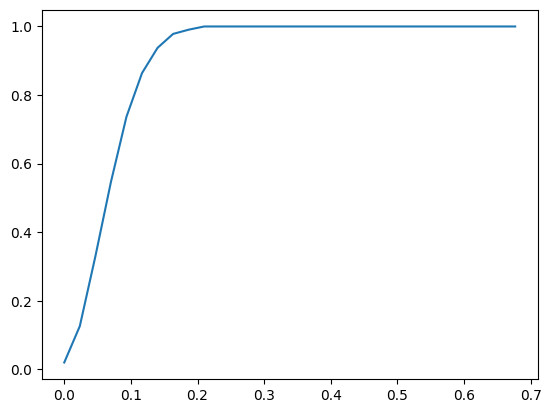

In [142]:
n_division=30
mat=np.nan_to_num(simi_matrices[128])
mat_jacc_ref=np.nan_to_num(similarity_matrix_bruteforce_jac)
threshold=0.1
count=[]
x0=[]
max_range=0.7 # there are no similarities above 0.7 in the dataset
for k in range(n_division):
    b1=k*max_range/n_division
    b2=(k+1)*max_range/n_division
    simi_in_interval = np.where(((mat>b1) & (mat<b2)))[0]
    count_simi_interval=len(simi_in_interval)
    simi_in_interval_true = np.where(((mat_jacc_ref>b1) & (mat_jacc_ref<b2)))[0]
    count_simi_interval_true=len(simi_in_interval_true)
    if count_simi_interval_true!=0:
        count.append(count_simi_interval/count_simi_interval_true)
    else:
        count.append(0)

    x0.append(b1)
plt.plot(x0,count)

### Evaluating different band sizes and nb_bands

In [57]:
np.random.seed(123)

signature_size=64
MH=MinHash(vector_size=threshold_rating_array.shape[1],n_rows=1,n_bands=64)


In [66]:
fill_buckets(threshold_rating_array,MH,verbose=True)
MH.hashes[2]

Filling buckets for user 610/610
Filled buckets in 0.48 seconds


{'2217,910': [0, 81, 95, 381, 390],
 '277,8358': [1, 48, 64, 318, 416],
 '5070,1053': [2],
 '2979,2843': [3],
 '450,123': [4, 39, 161, 234, 410, 469],
 '189,262': [5],
 '5259,910': [6,
  17,
  20,
  51,
  62,
  128,
  165,
  166,
  176,
  198,
  199,
  210,
  211,
  218,
  219,
  238,
  278,
  291,
  306,
  327,
  353,
  375,
  433,
  437,
  474,
  559,
  572,
  585,
  589],
 '508,123': [7,
  13,
  36,
  53,
  101,
  125,
  132,
  144,
  169,
  175,
  272,
  339,
  346,
  373,
  378,
  445,
  475,
  484,
  506,
  529,
  564,
  565,
  588,
  608],
 '4135,1258': [8],
 '5259,8952': [9],
 '1321,910': [10,
  18,
  32,
  56,
  123,
  131,
  194,
  201,
  233,
  262,
  265,
  356,
  452,
  521,
  524,
  533,
  569,
  592,
  593,
  599],
 '189,963': [11],
 '2979,2775': [12],
 '7749,910': [14, 247, 550],
 '4900,2795': [15],
 '3358,910': [16],
 '3986,2066': [19],
 '4900,5777': [21, 486, 600],
 '2979,936': [22],
 '1321,963': [23, 40],
 '7022,9691': [24],
 '192,123': [25,
  93,
  120,
  129,
  141

In [73]:
MH.__emptyhashes__()
MH.__changebands__(2,32)
print(MH.n_bands,MH.n_rows)

2 32


In [ ]:
# plt.figure(figsize=(10,8))
# cols=[p['color'] for p in plt.rcParams['axes.prop_cycle']]
# for k in range(6):
#     threshold=(k+3)/10
#     plt.plot([0,threshold],[0,0],c=cols[k])
#     plt.plot([threshold,threshold],[0,1],c=cols[k])
#     plt.plot([threshold,1],[1,1],c=cols[k])
# plt.title("Objective S curve, with different thresholds")
# plt.xlabel("Jaccart similarity")
# plt.ylabel("Probability of sharing at least one bucket")
# # # plt.savefig("Objective S curve.png")

In [ ]:
# plt.figure(figsize=(10,8))
# x=np.linspace(0,1,100)
# for b in range(1,20,3):
#     for r in range(1,20,3):
#         # print(b,r)
#         y=1-(1-x**r)**b
#         plt.plot(x,y)
# plt.plot(x,1-(1-x**10)**30000,c="blue")
# plt.title("S curve, when number of rows and bands evolve")
# plt.xlabel("Jaccart similarity")
# plt.ylabel("Probability of sharing at least one bucket")
# # plt.savefig("Evolution of s curve.png")

In [ ]:
# ratings=[]
# for user_id in range(20):
#     user_rating=[]
#     for movie_id in range(Preprocessing.ratings_array.shape[1]) :
#         print(f"Processing user : {user_id+1} movie : {movie_id+1}/{Preprocessing.ratings_array.shape[1]}",end="\r")
#         user_rating.append(
#             near_neighbor_prediction(preprocessing=Preprocessing,vectorIdx=user_id,
#                                 itemIdx=movie_id,lsh=MH,sim_function_label="jaccart")
#         )
#     ratings.append(user_rating)
# ratings=np.array(ratings)